# Adding measurements to `Schedule`s

Measurement is clearly a very important part of building a Pulse schedule -- this is required to get the results of our program execution! The powerful low-level control we are granted by Pulse gives us more freedom than `QuantumCircuit`s in specifying how the measurement should be done, enabling you to explore readout error mitigation. This power of course comes with responsibility: we have to understand how measurement works, and accomodate certain hardware constraints.

On this page, we will explore in depth how to create measurements, using several different approaches of increasing complexity.

**Note: Pulse allows you to receive raw, kerneled, and disciminated readout data (whereas circuits will only return discriminated data). Documentation for these options can be found here-COMING SOON.**

## Adding a backend-default measurement with `measure`
To add measurements as easily to `Schedule`s as to `QuantumCircuit`s, you just have to know which qubits you want to measure (below, qubits 0 and 1) and have a OpenPulse-enabled `backend`:

```
# Appending a measurement schedule to a Schedule, sched
from qiskit.scheduler import measure
sched += measure([0, 1], backend) << sched.duration
```
The `backend` contains a default definition for measurement, which is tailored to the qubits you are measuring.

## Basic measurement pattern and `measure_all`
Let's use the default measurement feature to inspect a measurement and learn what each pulse does. Below, we use `measure_all`, which measures all the qubits on the backend.

In [1]:
from qiskit.pulse import Schedule
from qiskit.scheduler import measure_all
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

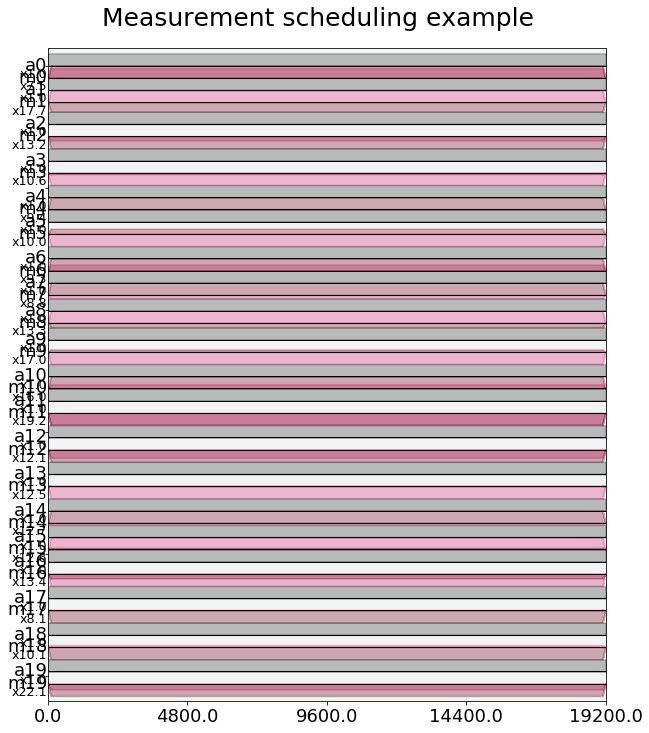

In [3]:
sched = Schedule(name="Measurement scheduling example")
sched += measure_all(backend)

sched.draw()

Each qubit has two channels related to readout, as we see above. These are the readout transmit `MeasureChannel`s, and the readout receive `AcquireChannel`s. In superconducting qubit architectures, qubits are coupled to readout resonators. The `MeasureChannel` and `AcquireChannel`s label signal lines which connect to the readout resonator. The coupling between the qubit and the readout resonator hybridizes their state, so when a stimulus pulse is sent to the readout resonantor, the reflected pulse is dependent on the state of the qubit. The acquisition "pulse" is truly a trigger specifying to the analog-to-digital converter (ADC) to begin collecting data, and for how long. That data is used to classify the qubit state.

### Specifying classical memory slots

If you would like to specify where your measurement results go, there is an option for that in `measure`, called `qubit_mem_slots`. It takes a dictionary mapping qubit indices to classical memory slots. For example, if you want to measure qubit 0 into memory slot 1, you would do this:

In [4]:
from qiskit.scheduler import measure

sched = measure(qubits=[0], backend=backend, qubit_mem_slots={0: 1})

This would be equivalent to the circuit measurement `circuit.measure(qubit_reg[0], classical_reg[1])`.

## Build a measurement sequence from pulses

Rather than use the default measurements provided by the backend, we can also build the measurement sequence up as a basic Pulse schedule. The example below is similar to a typical measurement on IBM systems.

First, we'll build the measurement stimulus pulses for each of the qubits we want to measure. Below, we use a Gaussian square parametric pulse.

In [5]:
from qiskit.pulse import MeasureChannel, AcquireChannel, MemorySlot, GaussianSquare, Acquire

# Duration (in number of cycles) for readout 
duration = 16000

# Stimulus pulses for qubits 0 and 1
measure_tx = GaussianSquare(duration=duration, amp=0.2, sigma=10, width=duration - 50)(MeasureChannel(0))
measure_tx += GaussianSquare(duration=duration, amp=0.2, sigma=10, width=duration - 50)(MeasureChannel(1))

/opt/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/pulse.py:49: DeprecationWarning: Calling `GaussianSquare` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(GaussianSquare(duration=16000, amp=(0.2+0j), sigma=10, width=15950), MeasureChannel(0))`.
  DeprecationWarning)
/opt/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/pulse.py:49: DeprecationWarning: Calling `GaussianSquare` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(GaussianSquare(duration=16000, amp=(0.2+0j), sigma=10, width=15950), MeasureChannel(1))`.
  DeprecationWarning)


Before we build the acquisition pulses, we need to understand the measurement map.

## Acquiring qubits: the measurement map `meas_map`

Due to control rack hardware constraints, some qubits may need to be acquired together. This can be the case for qubits whose readout channels are multiplexed. Any OpenPulse-enabled backend will provide a `meas_map` to notify the user of this.

For instance, if we see this for a 5-qubit `backend`

```
backend.configuration().meas_map

Out: [[0, 1, 2, 3, 4]]
```

then we know that all the qubits on this device must be acquired together. On the other hand, this output

```
Out: [[0], [1], [2], [3, 4]]
```

tells us that qubits 0, 1 and 2 can be acquired independently, but qubits 3 and 4 must be acquired together.

When building up a pulse schedule, be sure to add all the acquire pulses required by the backend you plan to run on. This is validated at assemble time.

Getting back to our example, let's imagine we plan to run on a backend with this measurement map: `[[0, 1, 2]]`. Now we can build the acquisition pulses. This is done with the `Acquire` command, which takes only a duration. We specify the channels and memory slots to acquire on.

In [6]:
# Acquisition instructions
acquire = Acquire(duration)
measure_rx = acquire(AcquireChannel(0), MemorySlot(0))
measure_rx += acquire(AcquireChannel(1), MemorySlot(1))

/opt/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/instructions/acquire.py:121: DeprecationWarning: Usage of Acquire without specifying a channel is deprecated. For example, Acquire(1200)(AcquireChannel(0)) should be replaced by Acquire(1200, AcquireChannel(0)).
  "Acquire(1200, AcquireChannel(0)).", DeprecationWarning)
/opt/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/instructions/acquire.py:218: DeprecationWarning: Calling Acquire with a channel is deprecated. Instantiate the acquire with a channel instead.
  "a channel instead.", DeprecationWarning)
/opt/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/instructions/acquire.py:218: DeprecationWarning: Calling Acquire with a channel is deprecated. Instantiate the acquire with a channel instead.
  "a channel instead.", DeprecationWarning)


Finally, we just combine the two parts together. Every instruction is on a different channel, so appending schedules the instructions at time 0. The `measure_schedule` can then be added to the end of any Pulse schedule to measure qubits 0 and 1 into classical memory slots 0 and 1.

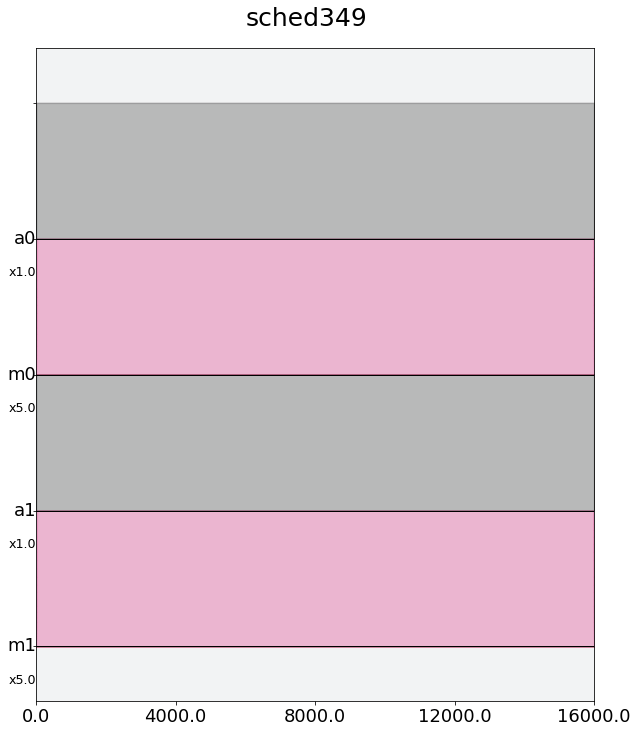

In [7]:
measure_sched = measure_tx + measure_rx

measure_sched.draw()

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright